# 1. Setup and Get Images

### 1.1 Install Dependencies

In [ ]:
%pip install labelme tensorflow opencv-python matplotlib albumentations labelme

### 1.2 Collect Images With OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
LABELS_PATH = os.path.join('data', 'labels')

TRAIN_IMAGES_PATH = os.path.join('data', 'train', 'images')
TEST_IMAGES_PATH = os.path.join('data', 'test', 'images')
VAL_IMAGES_PATH = os.path.join('data', 'val', 'images')

TRAIN_LABELS_PATH = os.path.join('data', 'train', 'labels')
TEST_LABELS_PATH = os.path.join('data', 'test', 'labels')
VAL_LABELS_PATH = os.path.join('data', 'val', 'labels')

AUG_TRAIN_IMAGES_PATH = os.path.join('aug_data', 'train', 'images')
AUG_TEST_IMAGES_PATH = os.path.join('aug_data', 'test', 'images')
AUG_VAL_IMAGES_PATH = os.path.join('aug_data', 'val', 'images')

AUG_TRAIN_LABELS_PATH = os.path.join('aug_data', 'train', 'labels')
AUG_TEST_LABELS_PATH = os.path.join('aug_data', 'test', 'labels')
AUG_VAL_LABELS_PATH = os.path.join('aug_data', 'val', 'labels')

# create folders to store the images
for path in [IMAGES_PATH, LABELS_PATH,
             TRAIN_IMAGES_PATH, TEST_IMAGES_PATH, VAL_IMAGES_PATH,
             TRAIN_LABELS_PATH, TEST_LABELS_PATH, VAL_LABELS_PATH,
             AUG_TRAIN_IMAGES_PATH, AUG_TEST_IMAGES_PATH, AUG_VAL_IMAGES_PATH,
             AUG_TRAIN_LABELS_PATH, AUG_TEST_LABELS_PATH, AUG_VAL_LABELS_PATH]:
    if not os.path.exists(path):
        os.makedirs(path)

In [3]:
number_images = 30
cam = cv2.VideoCapture(0) # 0 refers to webcam number
for imgnum in range(number_images): # collecting 30 images
    print('Collecting image {}'.format(imgnum))
    result, frame = cam.read() # read from capture device
    if result:
        imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
        cv2.imwrite(imgname, frame)
        cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'): # cv2 break out of loop code
        break
cam.release()
cv2.destroyAllWindows()

In [4]:
!labelme

2023-08-29 00:53:36.044 python[63163:1149170] +[CATransaction synchronize] called within transaction
2023-08-29 00:53:36.348 python[63163:1149170] +[CATransaction synchronize] called within transaction
2023-08-29 00:53:45.291 python[63163:1149170] +[CATransaction synchronize] called within transaction
2023-08-29 00:53:45.372 python[63163:1149170] +[CATransaction synchronize] called within transaction


# 2. Review Dataset and Load Images to TensorFlow

### 2.1 Import Dependencies

In [ ]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [6]:
# Avoid Out Of Memory (OOM) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

### 2.3 Load Images to TensorFlow Data Pipeline

In [7]:
# images contains a dataset of the full file paths to the images
images = tf.data.Dataset.list_files(os.path.join(IMAGES_PATH, '*.jpg'), shuffle=True)

In [8]:
# x is the full file path of the image
# load_image returns the actual image
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
# apply load_image to each of the images
images = images.map(load_image)

### 2.4 View Raw Images with Matplotlib

In [10]:
# put 4 images as a batch
# visualize 4 images at a time
image_generator = images.batch(4).as_numpy_iterator()

In [11]:
plot_images = image_generator.next()

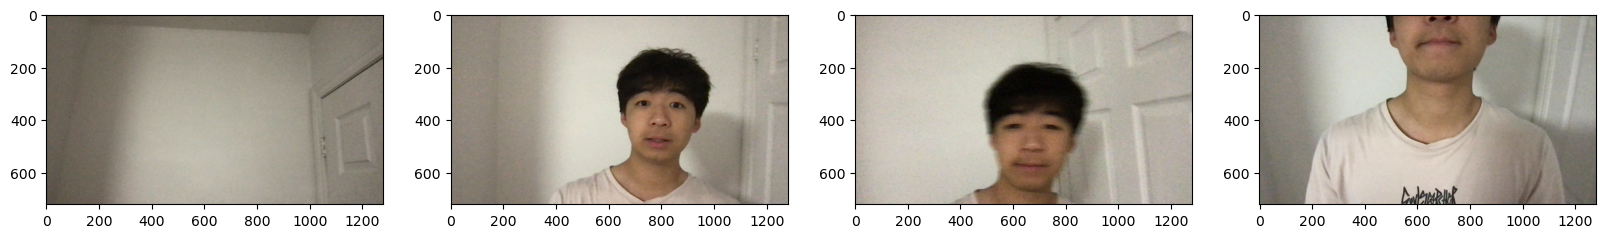

In [12]:
# figsize: width, height in inches
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 Randomly split data into train, test and val

In [13]:
image_count = len([file for file in os.listdir(IMAGES_PATH)])
train_count = int(image_count * 0.7)
test_count = int(image_count * 0.15)
val_count = image_count - train_count - test_count

In [14]:
import random

for i in range(train_count):
    random_file = random.choice(os.listdir(IMAGES_PATH))
    os.replace(os.path.join(IMAGES_PATH, random_file), os.path.join(TRAIN_IMAGES_PATH, random_file))

for i in range(test_count):
    random_file = random.choice(os.listdir(IMAGES_PATH))
    os.replace(os.path.join(IMAGES_PATH, random_file), os.path.join(TEST_IMAGES_PATH, random_file))

for i in range(val_count):
    random_file = random.choice(os.listdir(IMAGES_PATH))
    os.replace(os.path.join(IMAGES_PATH, random_file), os.path.join(VAL_IMAGES_PATH, random_file))

### 3.2 Move the Matching Labels

In [15]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)

        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [16]:
import albumentations as alb

In [17]:
crop_px = [450, 450]

# adding augmentations to images to generate "different" images
augmentor = alb.Compose([alb.RandomCrop(width=crop_px[0], height=crop_px[1]), # crop to 450 pixels
                         alb.HorizontalFlip(p=0.5), # p for proabibility
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2),
                         alb.RGBShift(p=0.2),
                         alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations',
                                                    label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [19]:
test_img_uuid = 'f48a14f0-4627-11ee-81df-acde48001122'
img = cv2.imread(os.path.join(TRAIN_IMAGES_PATH, f'{test_img_uuid}.jpg'))
img_height = img.shape[0]
img_width = img.shape[1]

In [20]:
with open(os.path.join(TRAIN_LABELS_PATH, f'{test_img_uuid}.json'), 'r') as f:
    label = json.load(f)

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [21]:
# the coords[0] and coords[1] is the x and y coords of the top left point, respectively
# the coords[2] and coords[3] is the x and y coords of the bottom right point, respectively
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [22]:
# transform image from the raw pascal_voc format to the albumentation format
# by dividing the cords by the width of the image and the height of the image
coords = list(np.divide(coords, [img_width, img_height, img_width, img_height]))

### 4.4 Apply Augmentations and View Results

In [23]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

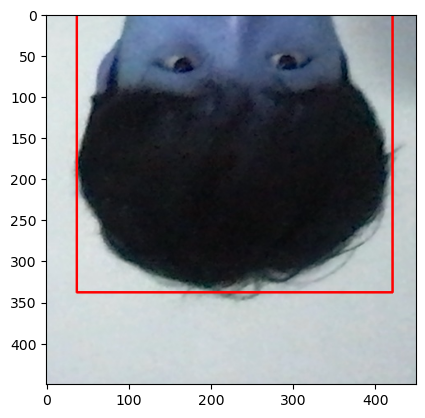

In [24]:
# augmented['bboxes'] is a list of 4 values, the first and second values represent the
# x and y coordinates of the first point of the label of the image, and the third
# and fourth values represnet the x and y coordinates of the second point
# [:2] = first two values
# [2:] = last two values
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], crop_px).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], crop_px).astype(int)), 
                    (255,0,0), 2) # BGR format, thickness

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [25]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        # get every image from train, test, and val
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        # default annotation coords for images with no annotations
        coords = [0,0,0.00001,0.00001]

        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')

        # if annotation for the image exists
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            # load the labels into coords
            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [img_width, img_height, img_width, img_height]))

        try: 
            for x in range(60): # create 60 augmented images for 1 base image
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1 # class is 1 indicating there is an annotation / face
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 # class is 0 for no annotation / face


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [26]:
# compress images even more for more efficient neural network (less data to process)
resize_px = (120, 120)

train_images = tf.data.Dataset.list_files(os.path.join(AUG_TRAIN_IMAGES_PATH, '*.jpg'), shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, resize_px))
train_images = train_images.map(lambda x: x/255)

In [27]:
test_images = tf.data.Dataset.list_files(os.path.join(AUG_TEST_IMAGES_PATH, '*.jpg'), shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, resize_px))
test_images = test_images.map(lambda x: x/255)

In [28]:
val_images = tf.data.Dataset.list_files(os.path.join(AUG_VAL_IMAGES_PATH, '*.jpg'), shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, resize_px))
val_images = val_images.map(lambda x: x/255)

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [29]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [30]:
train_labels = tf.data.Dataset.list_files(os.path.join(AUG_TRAIN_LABELS_PATH, '*.json'), shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
test_labels = tf.data.Dataset.list_files(os.path.join(AUG_TEST_LABELS_PATH, '*.json'), shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [32]:
val_labels = tf.data.Dataset.list_files(os.path.join(AUG_VAL_LABELS_PATH, '*.json'), shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [33]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(1260, 1260, 240, 240, 300, 300)

### 7.2 Create Final Datasets (Images/Labels)

In [34]:
# zip: combine the images with the labels
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8) # each batch contains 8 images and 8 labels
train = train.prefetch(4) # avoid bottlenecks

In [35]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [36]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### 7.3 View Images and Annotations

In [37]:
data_samples = train.as_numpy_iterator()

In [38]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


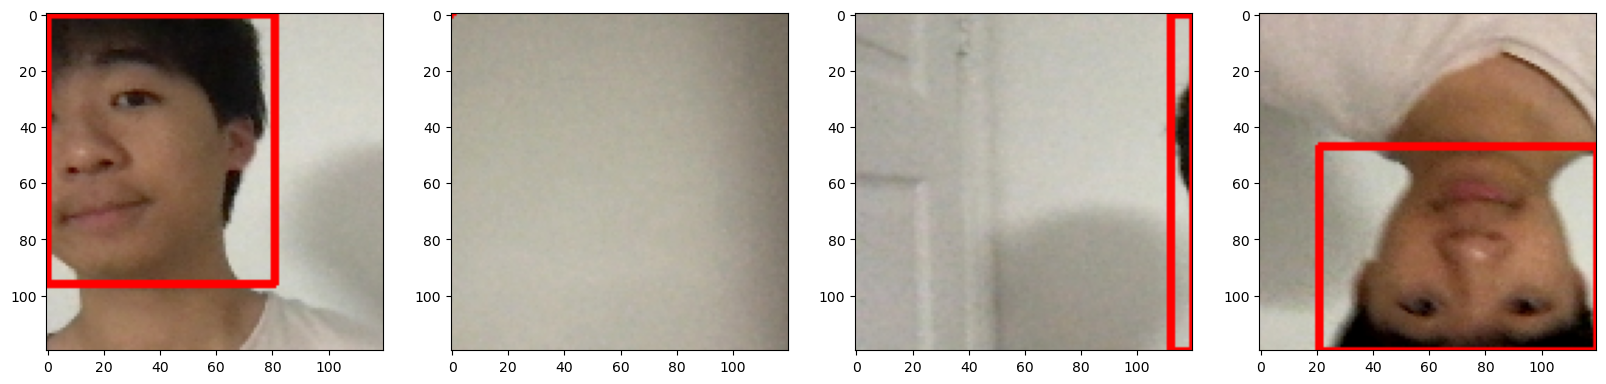

In [39]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [resize_px[0], resize_px[1]]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [resize_px[0], resize_px[1]]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [40]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [41]:
vgg = VGG16(include_top=False)

In [42]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [43]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)


    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    # 1 output value
    # sigmoid layer: output is between 0 and 1
    class2 = Dense(1, activation='sigmoid')(class1)


    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    # 4 outputs
    # sigmoid layer: output is between 0 and 1
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [44]:
facetracker = build_model()

In [45]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [46]:
X, y = train.as_numpy_iterator().next()

In [47]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 1s 609ms/step


In [48]:
classes, coords

(array([[0.57829195],
        [0.44834056],
        [0.57404876],
        [0.5802711 ],
        [0.5836741 ],
        [0.5771317 ],
        [0.5767059 ],
        [0.44036454]], dtype=float32),
 array([[0.53433645, 0.35790458, 0.54821944, 0.3212015 ],
        [0.5200326 , 0.3761147 , 0.64051676, 0.25327405],
        [0.5345425 , 0.37837842, 0.54630667, 0.32151726],
        [0.53396446, 0.3534553 , 0.54360217, 0.34557486],
        [0.53031164, 0.35634935, 0.54125994, 0.32264796],
        [0.5360931 , 0.35645118, 0.53733605, 0.32770208],
        [0.5247349 , 0.35298273, 0.5444037 , 0.33724526],
        [0.5236791 , 0.3758912 , 0.6102586 , 0.25227115]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [49]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch # learning rate decay

In [50]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [51]:
def localization_loss(y_true, yhat):
    # getting the distance between actual coords and predicted coords 
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] # actual height
    w_true = y_true[:,2] - y_true[:,0] # actualy width

    h_pred = yhat[:,3] - yhat[:,1] # predicted height
    w_pred = yhat[:,2] - yhat[:,0] # predicted width
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [52]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [53]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.6001406>

In [54]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.81320643>

In [55]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.6001406>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [56]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker # pass in pre-built neutral network

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        # takes one batch of data and train it
        # X = preprocessed images
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            # y[0] - classification value (1 or 0): y true
            # classes - the true 1 or 0: y pred
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            # combining classloss and localizationloss to get one loss metric
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            # caluclate gradient wrt loss function
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    # triggered through validation dataset
    # similar to train_step()
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    # for model.predict() if every used
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [57]:
model = FaceTracker(facetracker)

In [58]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [59]:
logdir='logs'

In [60]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [62]:
# fit() will trigger train_step()
# train for 10 epochs
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
158/158 [==============================] - 230s 1s/step - total_loss: 0.1704 - class_loss: 0.0306 - regress_loss: 0.1551 - val_total_loss: 1.0504 - val_class_loss: 0.9549 - val_regress_loss: 0.5730
Epoch 2/10
158/158 [==============================] - 214s 1s/step - total_loss: 0.1608 - class_loss: 0.0381 - regress_loss: 0.1417 - val_total_loss: 4.9010 - val_class_loss: 4.4777 - val_regress_loss: 2.6622
Epoch 3/10
158/158 [==============================] - 212s 1s/step - total_loss: 0.0972 - class_loss: 0.0277 - regress_loss: 0.0834 - val_total_loss: 4.6154 - val_class_loss: 4.2755 - val_regress_loss: 2.4776
Epoch 4/10
158/158 [==============================] - 209s 1s/step - total_loss: 0.0567 - class_loss: 0.0175 - regress_loss: 0.0479 - val_total_loss: 1.7045 - val_class_loss: 1.8431 - val_regress_loss: 0.7830
Epoch 5/10
158/158 [==============================] - 212s 1s/step - total_loss: 0.0435 - class_loss: 0.0140 - regress_loss: 0.0365 - val_total_loss: 1.9764 - val_c

### 10.3 Plot Performance

In [63]:
hist.history

{'total_loss': [0.03606449440121651,
  0.013394048437476158,
  0.004226867575198412,
  0.019332997500896454,
  0.019358059391379356,
  0.007601430639624596,
  0.007937534712255001,
  0.020661965012550354,
  0.0037974684964865446,
  0.004708712920546532],
 'class_loss': [0.0013016974553465843,
  0.018166210502386093,
  0.0014770907582715154,
  0.0023274989798665047,
  1.8775521084535285e-06,
  3.263364760641707e-06,
  0.00046783231664448977,
  0.020952275022864342,
  0.0004046535468660295,
  2.011661536016618e-06],
 'regress_loss': [0.03541364520788193,
  0.004310943186283112,
  0.0034883220214396715,
  0.01816924847662449,
  0.019357120618224144,
  0.007599798962473869,
  0.00770361814647913,
  0.010185827501118183,
  0.0035951416939496994,
  0.004707707092165947],
 'val_total_loss': [1.050396203994751,
  4.901010513305664,
  4.615401268005371,
  1.7044835090637207,
  1.976426362991333,
  1.5082241296768188,
  4.599818229675293,
  5.081544876098633,
  2.2232484817504883,
  1.2785246372

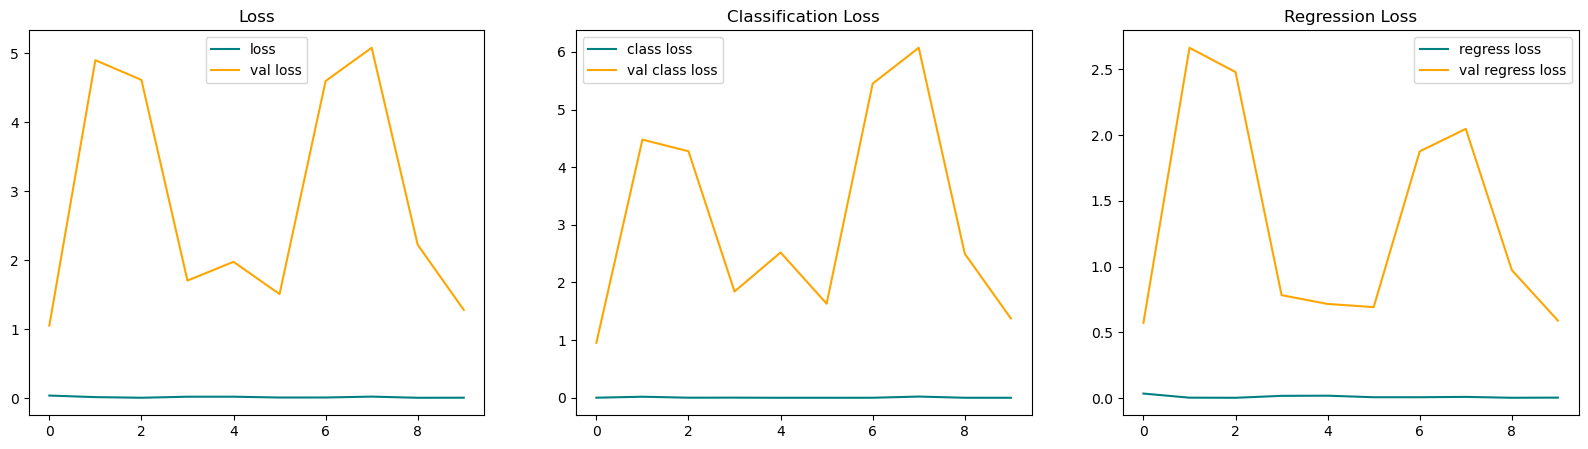

In [64]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [65]:
test_data = test.as_numpy_iterator()

In [66]:
test_sample = test_data.next()

In [67]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 354ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


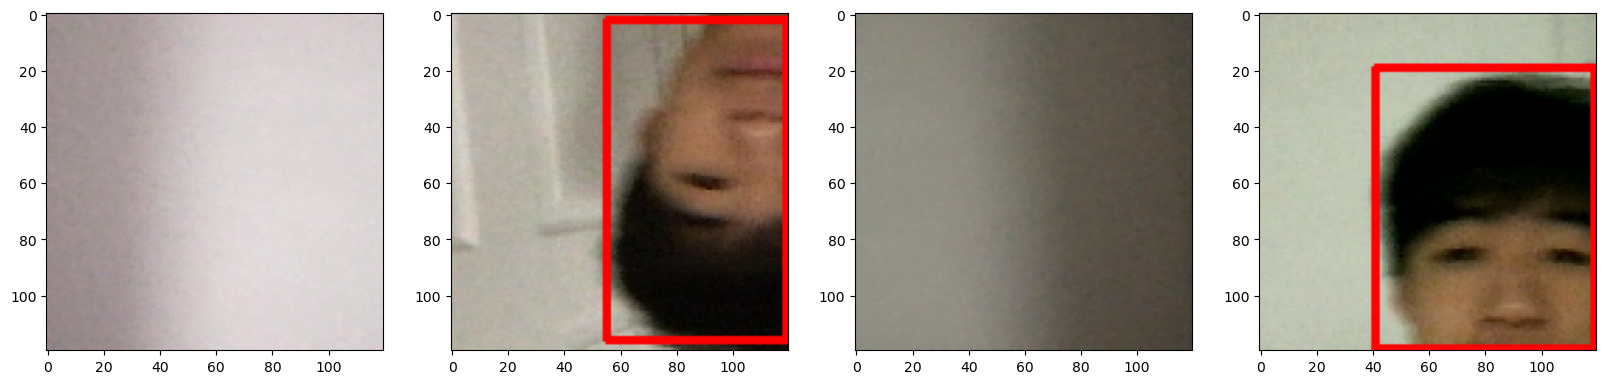

In [68]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    # only plot if classification loss is over 0.5
    if yhat[0][idx] > 0.5:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [69]:
from tensorflow.keras.models import load_model

In [70]:
facetracker.save('facetracker.h5')

/Users/patrick/anaconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [71]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cam = cv2.VideoCapture(0)
while cam.isOpened():
    _ , frame = cam.read()
    # cut down to 450 pixels
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, resize_px)
    
    yhat = facetracker.predict(np.expand_dims(resized / 255, 0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], crop_px).astype(int)),
                      tuple(np.multiply(sample_coords[2:], crop_px).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], crop_px).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], crop_px).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], crop_px).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('Face Track', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cam.release()
cv2.destroyAllWindows()

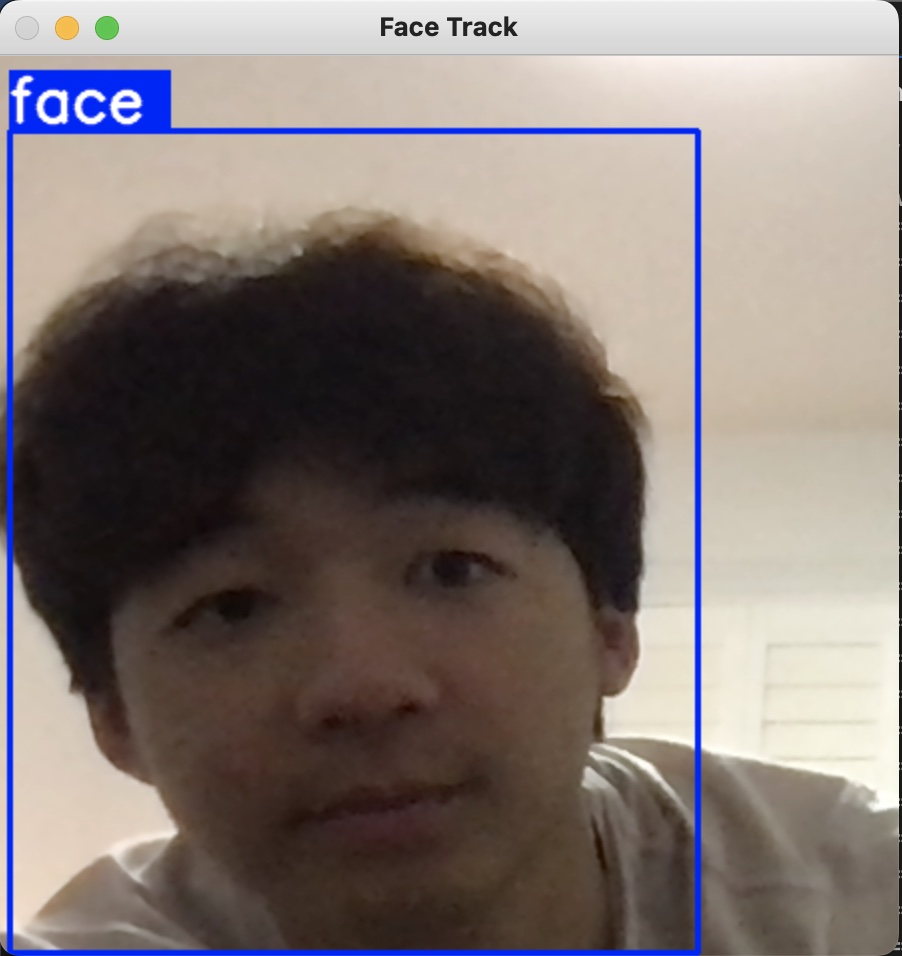

In [1]:
from IPython.display import Image, display
display(Image(filename='result.jpg', width=300, height=300))